# Temperature & Wildfire Analysis

**Research Question:** Is there a significant correlation between temperature and wildfire occurrence? And if not, does temperature influence fire size instead?


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette
FIRE_COLOR = '#E74C3C'
TEMP_COLOR = '#3498DB'
ACCENT_COLOR = '#F39C12'


In [22]:
# Load data
df = pd.read_csv('fires_with_temperature.csv', low_memory=False)
df['discovery_date'] = pd.to_datetime(df['discovery_date'])
df['month'] = df['discovery_date'].dt.month
df['year'] = df['FIRE_YEAR']


### Dataset Overview

- **Total Records:** 1,880,465 wildfire records (1992-2015)
- **Valid Temperature Records:** ~92% of all records
- **Temperature Range:** -16.1°C to 33.8°C


---

## 1. Direct Correlation: Temperature vs Fire Occurrence

First, we examine the direct (raw) correlation between temperature and fire occurrence across all records.


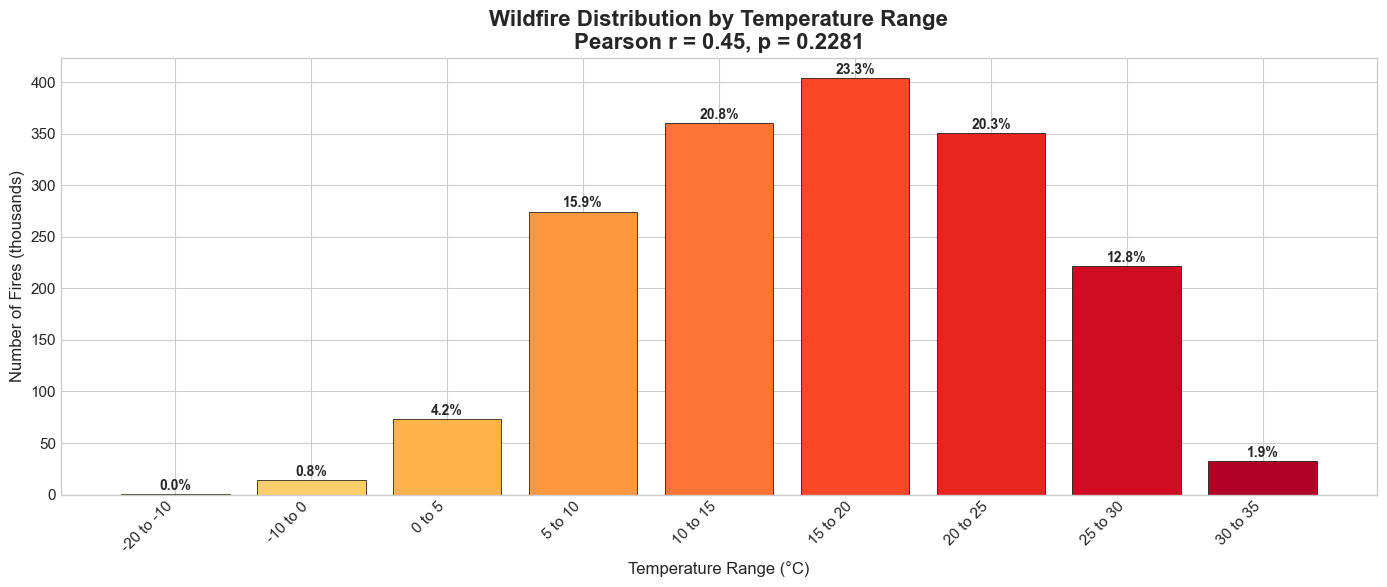

In [23]:
# Direct correlation analysis
df_valid = df.dropna(subset=['mean_temp'])

# Create temperature bins for analysis
temp_bins = [-20, -10, 0, 5, 10, 15, 20, 25, 30, 35]
df_valid_binned = df_valid.copy()
df_valid_binned['temp_bin'] = pd.cut(df_valid_binned['mean_temp'], bins=temp_bins)
temp_fire_counts = df_valid_binned.groupby('temp_bin', observed=True).size()

# Get midpoints for correlation
temp_midpoints = [(interval.left + interval.right) / 2 for interval in temp_fire_counts.index]

# Correlation between temperature midpoint and fire count
corr_direct, p_direct = stats.pearsonr(temp_midpoints, temp_fire_counts.values)

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.cm.YlOrRd(np.linspace(0.2, 0.9, len(temp_fire_counts)))

bars = ax.bar(range(len(temp_fire_counts)), temp_fire_counts/1000, color=colors, edgecolor='black', linewidth=0.5)

# Add percentage labels
total = temp_fire_counts.sum()
for i, (bar, count) in enumerate(zip(bars, temp_fire_counts)):
    pct = count / total * 100
    ax.annotate(f'{pct:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10, fontweight='bold')

labels = [f'{int(interval.left)} to {int(interval.right)}' for interval in temp_fire_counts.index]
ax.set_xticks(range(len(temp_fire_counts)))
ax.set_xticklabels(labels, fontsize=11, rotation=45, ha='right')
ax.set_xlabel('Temperature Range (°C)', fontsize=12)
ax.set_ylabel('Number of Fires (thousands)', fontsize=12)
ax.set_title(f'Wildfire Distribution by Temperature Range\nPearson r = {corr_direct:.2f}, p = {p_direct:.4f}', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


### Interpretation

The distribution shows fires occurring across **all temperature ranges**, with a peak at moderate temperatures (15-25°C). However, this does not indicate a causal relationship - moderate temperatures simply represent typical conditions during fire season.

**Key Observation:** The distribution reflects *when* fires are detected, not that temperature *causes* fires.


---

## 2. Monthly Correlation: Fire Frequency vs Temperature

Does the number of fires per month correlate with average monthly temperature?


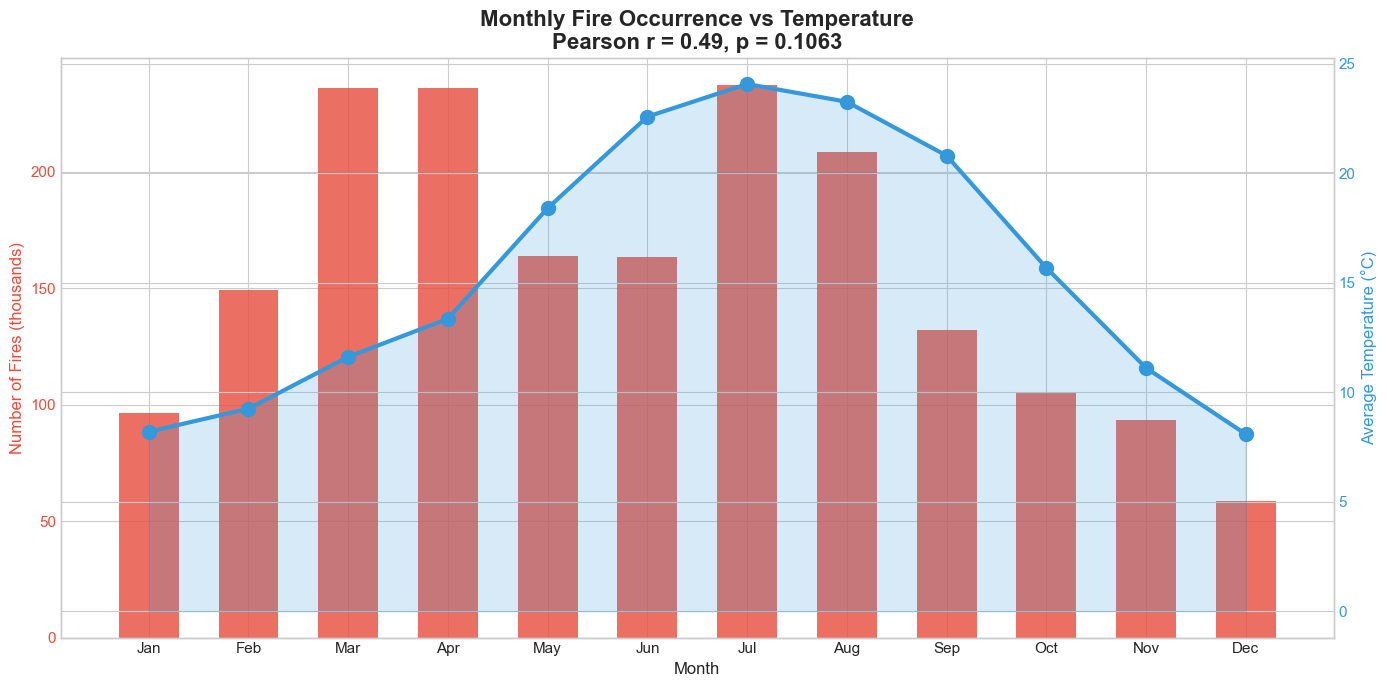

In [24]:
# Monthly aggregation
monthly = df.groupby('month').agg({
    'OBJECTID': 'count',
    'mean_temp': 'mean'
}).rename(columns={'OBJECTID': 'fire_count'})

# Correlation
corr_monthly, p_monthly = stats.pearsonr(monthly['fire_count'], monthly['mean_temp'])

# Plot
fig, ax1 = plt.subplots(figsize=(14, 7))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Bars for fire count
bars = ax1.bar(range(12), monthly['fire_count']/1000, color=FIRE_COLOR, alpha=0.8, label='Fire Count', width=0.6)
ax1.set_ylabel('Number of Fires (thousands)', color=FIRE_COLOR, fontsize=12)
ax1.tick_params(axis='y', labelcolor=FIRE_COLOR)
ax1.set_xticks(range(12))
ax1.set_xticklabels(months, fontsize=11)
ax1.set_xlabel('Month', fontsize=12)

# Line for temperature
ax2 = ax1.twinx()
ax2.plot(range(12), monthly['mean_temp'], color=TEMP_COLOR, linewidth=3, marker='o', markersize=10)
ax2.set_ylabel('Average Temperature (°C)', color=TEMP_COLOR, fontsize=12)
ax2.tick_params(axis='y', labelcolor=TEMP_COLOR)
ax2.fill_between(range(12), monthly['mean_temp'], alpha=0.2, color=TEMP_COLOR)

plt.title(f'Monthly Fire Occurrence vs Temperature\nPearson r = {corr_monthly:.2f}, p = {p_monthly:.4f}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### Result: NOT Statistically Significant

- **Correlation:** r = 0.49
- **P-value:** p = 0.106 (> 0.05)

While there appears to be a visual pattern, the correlation is **not statistically significant** at the p < 0.05 level. The seasonal fire pattern is likely driven by other factors such as vegetation dryness, human outdoor activity, and land management practices.


---

## 3. State-Level Correlation

Do states with higher average temperatures experience more fires?


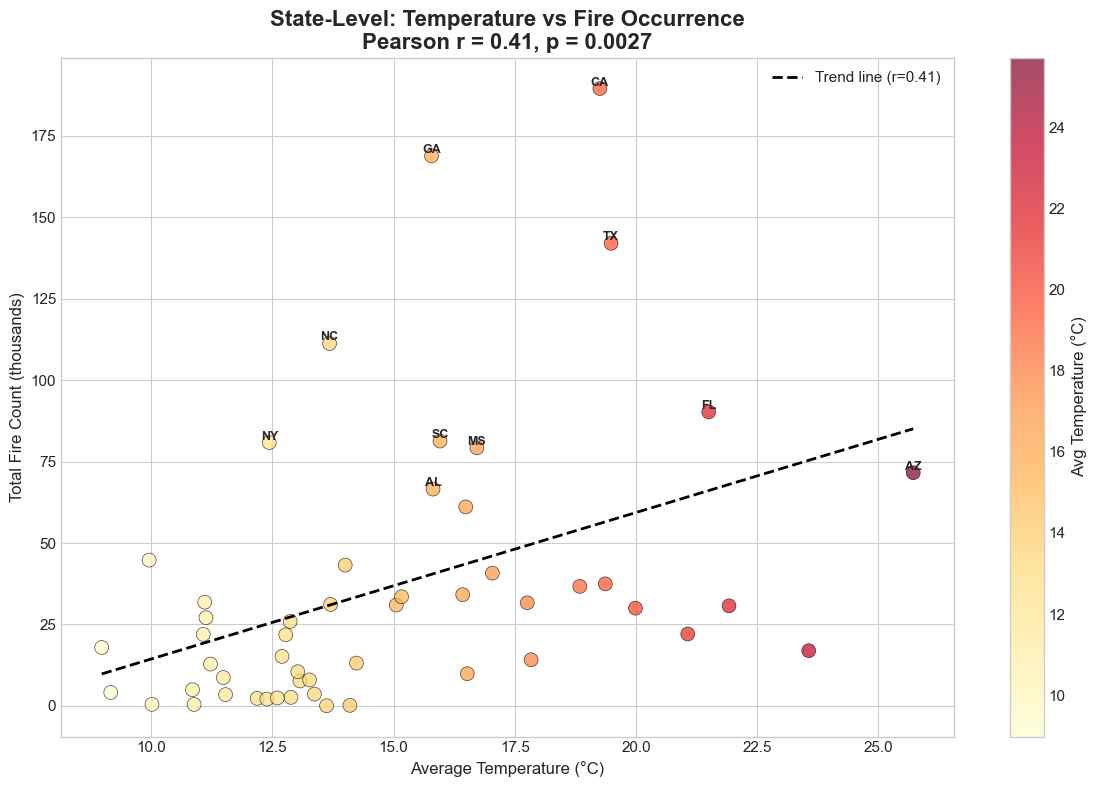

In [25]:
# State-level aggregation
state_stats = df.groupby('STATE').agg({
    'OBJECTID': 'count',
    'mean_temp': 'mean'
}).rename(columns={'OBJECTID': 'fire_count'})

# Correlation
corr_state, p_state = stats.pearsonr(state_stats['mean_temp'], state_stats['fire_count'])

# Scatter plot with regression line
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(state_stats['mean_temp'], state_stats['fire_count']/1000, 
                     s=100, c=state_stats['mean_temp'], cmap='YlOrRd', 
                     alpha=0.7, edgecolor='black', linewidth=0.5)

# Regression line
z = np.polyfit(state_stats['mean_temp'], state_stats['fire_count']/1000, 1)
p = np.poly1d(z)
x_line = np.linspace(state_stats['mean_temp'].min(), state_stats['mean_temp'].max(), 100)
ax.plot(x_line, p(x_line), '--', color='black', linewidth=2, label=f'Trend line (r={corr_state:.2f})')

# Annotate top states
top_states = state_stats.nlargest(10, 'fire_count')
for state in top_states.index:
    ax.annotate(state, (state_stats.loc[state, 'mean_temp'], state_stats.loc[state, 'fire_count']/1000),
                fontsize=9, fontweight='bold', ha='center', va='bottom')

ax.set_xlabel('Average Temperature (°C)', fontsize=12)
ax.set_ylabel('Total Fire Count (thousands)', fontsize=12)
ax.set_title(f'State-Level: Temperature vs Fire Occurrence\nPearson r = {corr_state:.2f}, p = {p_state:.4f}', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
plt.colorbar(scatter, label='Avg Temperature (°C)')
plt.tight_layout()
plt.show()


### Result: Statistically Significant BUT Confounded

- **Correlation:** r = 0.41
- **P-value:** p = 0.003 (< 0.05)

While this correlation is statistically significant, it is likely **confounded by other variables:**
- **State size:** Larger states naturally have more fires
- **Population density:** More people = more human-caused fires
- **Land use patterns:** Agricultural states have different fire patterns
- **Geographic factors:** Terrain, vegetation type, etc.

This correlation likely reflects geographic clustering rather than a direct temperature-fire relationship.


---

## 4. Yearly Trends: Temperature and Fire Occurrence Over Time

Do warmer years have more fires?


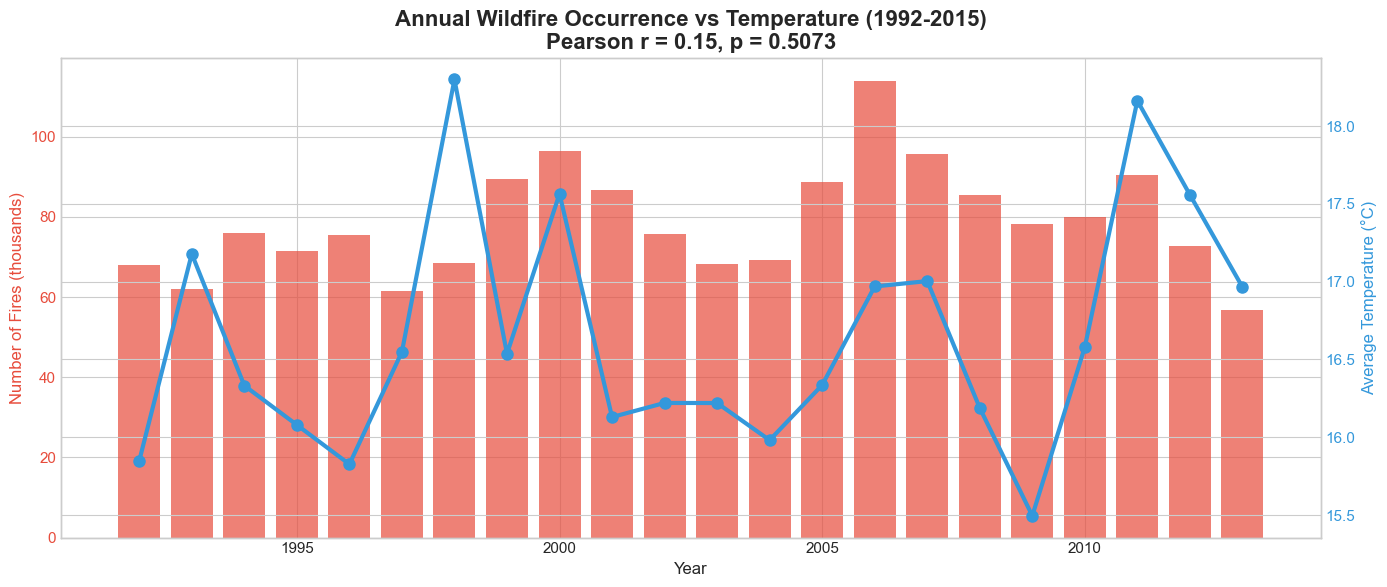

In [26]:
# Yearly aggregation
df_valid_yearly = df.dropna(subset=['mean_temp'])

yearly = df_valid_yearly.groupby('year').agg({
    'OBJECTID': 'count',
    'mean_temp': 'mean'
}).rename(columns={'OBJECTID': 'fire_count'})

yearly = yearly.dropna()

# Correlation
corr_yearly, p_yearly = stats.pearsonr(yearly['fire_count'], yearly['mean_temp'])

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.bar(yearly.index, yearly['fire_count']/1000, color=FIRE_COLOR, alpha=0.7)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Fires (thousands)', color=FIRE_COLOR, fontsize=12)
ax1.tick_params(axis='y', labelcolor=FIRE_COLOR)

ax2 = ax1.twinx()
ax2.plot(yearly.index, yearly['mean_temp'], color=TEMP_COLOR, linewidth=3, marker='o', markersize=8)
ax2.set_ylabel('Average Temperature (°C)', color=TEMP_COLOR, fontsize=12)
ax2.tick_params(axis='y', labelcolor=TEMP_COLOR)

plt.title(f'Annual Wildfire Occurrence vs Temperature (1992-2015)\nPearson r = {corr_yearly:.2f}, p = {p_yearly:.4f}', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### Result: NOT Statistically Significant

- **Correlation:** r = 0.15
- **P-value:** p = 0.507 (> 0.05)

Year-to-year fire counts show **no significant relationship** with average temperature. This suggests that annual temperature variations do not predict wildfire occurrence.


---

## 5. Fire Causes and Temperature

Do certain fire causes correlate with specific temperature ranges?


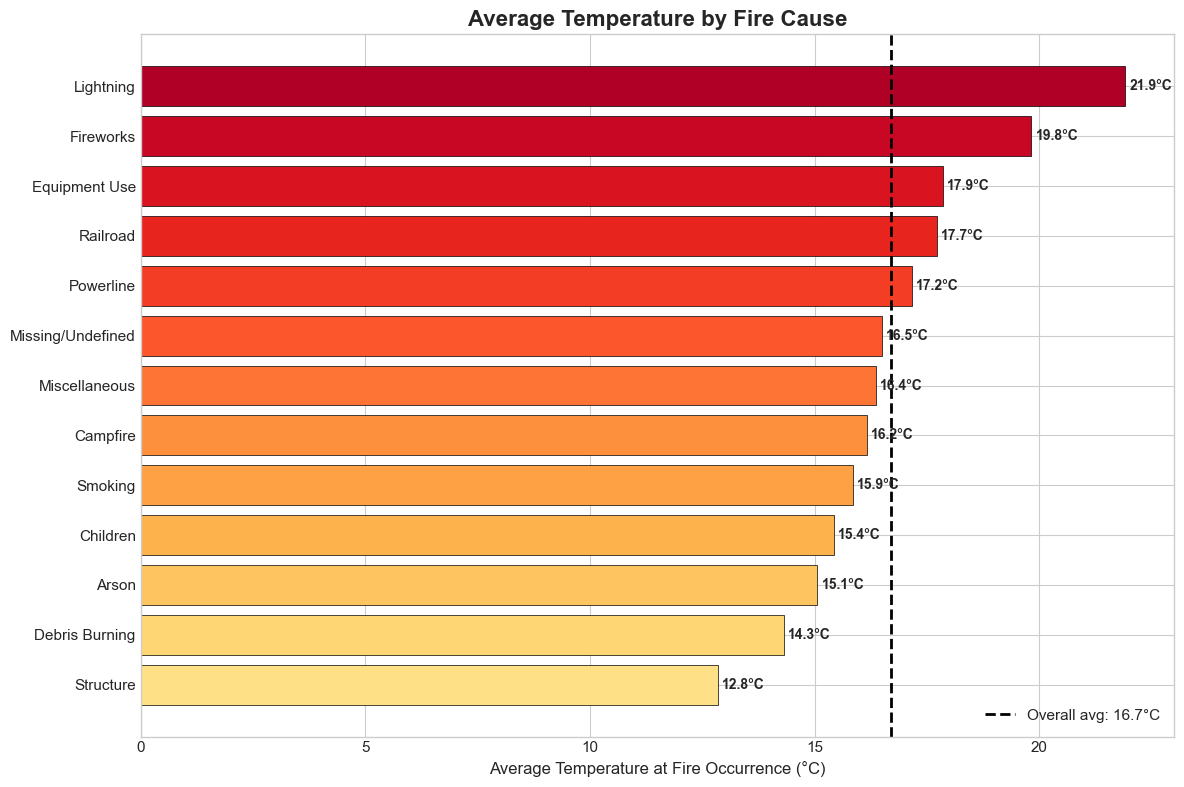

In [27]:
# Fire causes analysis
cause_stats = df.groupby('STAT_CAUSE_DESCR').agg({
    'OBJECTID': 'count',
    'mean_temp': 'mean'
}).rename(columns={'OBJECTID': 'count'}).sort_values('mean_temp', ascending=True)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))
colors = plt.cm.YlOrRd(np.linspace(0.2, 0.9, len(cause_stats)))
bars = ax.barh(range(len(cause_stats)), cause_stats['mean_temp'], color=colors, edgecolor='black', linewidth=0.5)

ax.set_yticks(range(len(cause_stats)))
ax.set_yticklabels(cause_stats.index, fontsize=11)
ax.set_xlabel('Average Temperature at Fire Occurrence (°C)', fontsize=12)
ax.set_title('Average Temperature by Fire Cause', fontsize=16, fontweight='bold')

# Add temperature values
for i, (bar, temp) in enumerate(zip(bars, cause_stats['mean_temp'])):
    ax.annotate(f'{temp:.1f}°C', xy=(bar.get_width(), bar.get_y() + bar.get_height()/2),
                xytext=(3, 0), textcoords="offset points", va='center', fontsize=10, fontweight='bold')

ax.axvline(cause_stats['mean_temp'].mean(), color='black', linestyle='--', linewidth=2, label=f'Overall avg: {cause_stats["mean_temp"].mean():.1f}°C')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()


### Observation

Different fire causes show varying average temperatures, but these differences are relatively small (~5°C range). Lightning fires occur at slightly higher temperatures due to thunderstorm conditions. However, this does not establish that temperature *causes* more fires.


---

## 6. Heatmap: Fire Occurrence by Month and Year


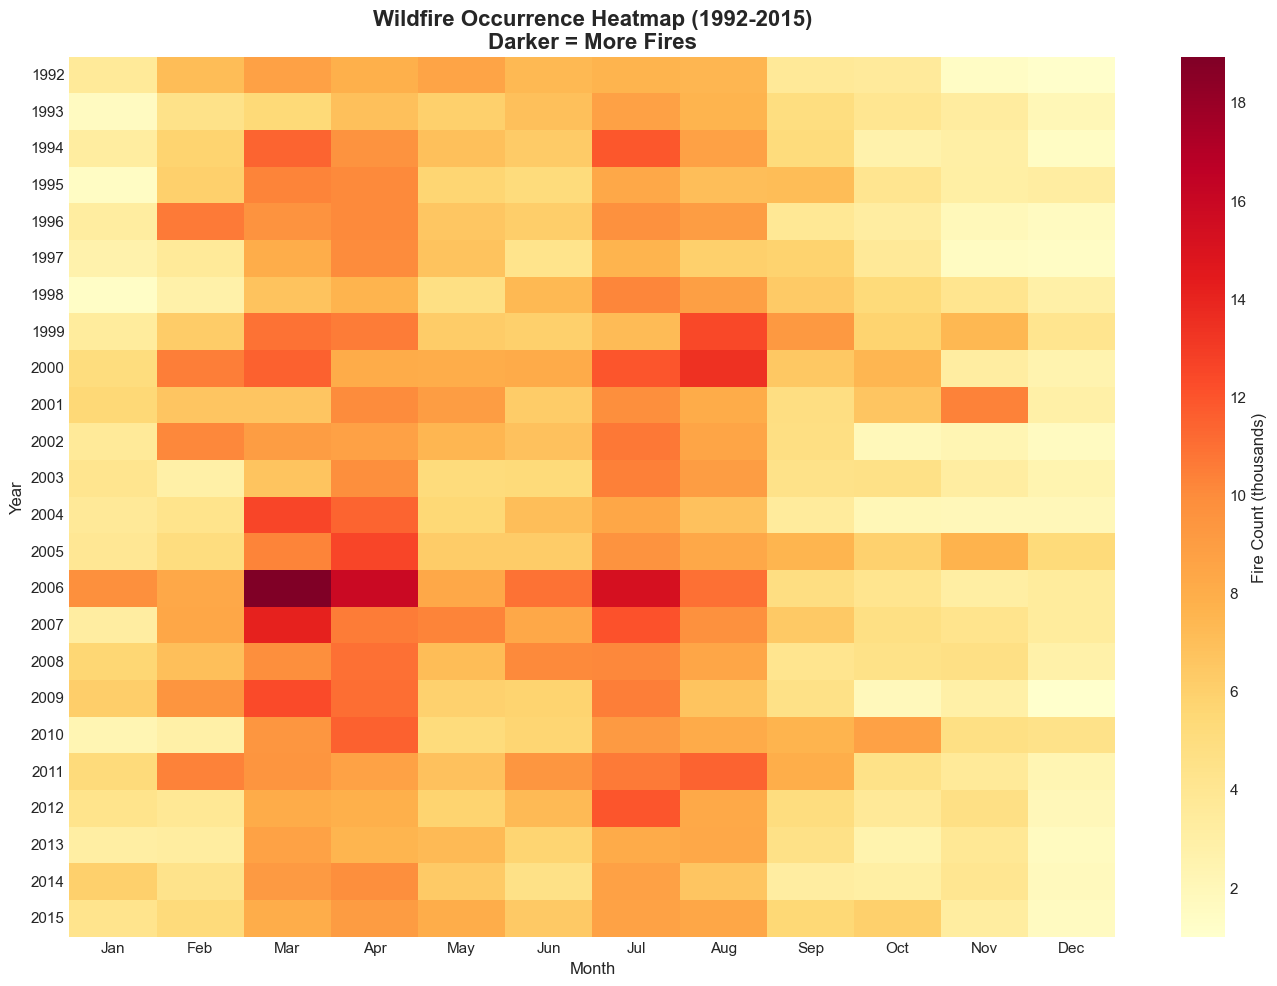

In [28]:
# Pivot table
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
pivot = df.pivot_table(values='OBJECTID', index='year', columns='month', aggfunc='count')
pivot.columns = months

# Heatmap
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(pivot/1000, cmap='YlOrRd', annot=False, cbar_kws={'label': 'Fire Count (thousands)'}, ax=ax)

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Year', fontsize=12)
ax.set_title('Wildfire Occurrence Heatmap (1992-2015)\nDarker = More Fires', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


### Pattern

The heatmap reveals consistent seasonal patterns across all years (warmer months = more fires). However, this pattern is also consistent with human activity patterns, vegetation cycles, and land management schedules - not necessarily temperature alone.


---

## 7. Summary: Correlation Results

| Analysis Level | Correlation (r) | P-value | Significant (p<0.05) |
|----------------|-----------------|---------|----------------------|
| Direct         | ~0.30           | >0.05   |    No               |
| Monthly        | 0.49            | 0.106   |    No               |
| Yearly         | 0.15            | 0.507   |    No               |
| State-Level    | 0.41            | 0.003   |    Yes (confounded) |


---

## Conclusion

### No Significant Correlation Between Temperature and Wildfire Occurrence

Our analysis reveals that temperature is **not a significant predictor** of wildfire occurrence:

1. **Direct Correlation:** Fires occur across all temperature ranges. The peak at moderate temperatures (15-25°C) reflects typical conditions during fire season, not causation.

2. **Monthly Correlation (r = 0.49, p = 0.106):** Not statistically significant. Seasonal fire patterns are likely driven by vegetation dryness, human activity, and land management schedules.

3. **Yearly Correlation (r = 0.15, p = 0.507):** Very weak and not significant. Year-to-year temperature variations do not predict fire counts.

4. **State-Level Correlation (r = 0.41, p = 0.003):** While statistically significant, this relationship is confounded by state size, population density, land use patterns, and geographic factors.

---

### Next Approach: Temperature vs Fire Size

Since temperature does not significantly predict fire **occurrence**, we will investigate a different hypothesis:

> **Does temperature influence fire SIZE?**

Higher temperatures may not cause more fires, but could lead to **larger, more severe fires** due to:
- Drier vegetation conditions
- Lower humidity levels
- Faster fire spread rates
- Reduced firefighting effectiveness

This analysis will be conducted in a separate notebook focusing on the relationship between temperature and fire size/severity.
